# Seq2seq for Copying Task
Guorui Shen, guorui233@outlook.com

Jun 13, 2019.

Tutorial for beginer to start building a seq2seq model. Modified from https://github.com/ematvey/tensorflow-seq2seq-tutorials

**Task description**. Given a input, which is a list of integer numbers, the seq2seq model is trained to remember and return the list. For example,
```
raw input        -> padded to have same length -> expected output
[3 6 7 3 4 5 3 ] -> [3 6 7 3 4 5 3 0]          -> [3 6 7 3 4 5 3 1 0]
[5 3 5 4 7]      -> [5 3 5 4 7 0 0 0]          -> [5 3 5 4 7 1 0 0 0]
[2 9 5]          -> [2 9 5 0 0 0 0 0]          -> [2 9 5 1 0 0 0 0 0]
```
eos = 1, pad = 0.

In [1]:
import numpy as np
import tensorflow as tf
import scipy.io as sio

tf.reset_default_graph()
sess = tf.InteractiveSession()

## 1 - Load Data
`PAD = 0`, `EOS = 1`

In [2]:
data = sio.loadmat('copytask.mat')

def next_batch(x, y, z, batch_size):
    N = x.shape[1]
    batch_indices = np.random.permutation(N)[:batch_size]
    return x[:, batch_indices], y[:, batch_indices], z[:, batch_indices]

In [3]:
batch_size = 100
batch_encoder_inputs, batch_decoder_inputs, batch_decoder_targets = next_batch(
    data['encoder_inputs'], data['decoder_inputs'], data['decoder_targets'], batch_size)

In [4]:
encoder_max_unrolling_time = len(batch_encoder_inputs)
decoder_max_unrolling_time = len(batch_decoder_inputs)
print("batch_encoder_inputs.shape = (encoder_max_unrolling_time, batch_size) = {}".format(batch_encoder_inputs.shape))
print("batch_decoder_inputs.shape = (decoder_max_unrolling_time, batch_size) = {}".format(batch_decoder_inputs.shape))
print("batch_decoder_targets.shape = (decoder_max_unrolling_time, batch_size) = {}".format(batch_decoder_targets.shape))
for i in range(2):
    print('--------------example {}---------------'.format(i+1))
    print('encoder_input is  {}'.format(batch_encoder_inputs[:, i]))
    print('decoder_input is  {}'.format(batch_decoder_inputs[:, i]))
    print('decoder_target is {}'.format(batch_decoder_targets[:, i]))

batch_encoder_inputs.shape = (encoder_max_unrolling_time, batch_size) = (8, 100)
batch_decoder_inputs.shape = (decoder_max_unrolling_time, batch_size) = (9, 100)
batch_decoder_targets.shape = (decoder_max_unrolling_time, batch_size) = (9, 100)
--------------example 1---------------
encoder_input is  [7 3 5 5 7 5 0 0]
decoder_input is  [1 7 3 5 5 7 5 0 0]
decoder_target is [7 3 5 5 7 5 1 0 0]
--------------example 2---------------
encoder_input is  [9 6 2 0 0 0 0 0]
decoder_input is  [1 9 6 2 0 0 0 0 0]
decoder_target is [9 6 2 1 0 0 0 0 0]


In [5]:
# # deletable
# encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, batch_encoder_inputs)
# print(sess.run(encoder_inputs_embedded).shape)
# print(sess.run(encoder_inputs_embedded)[:, :, :5])

## 2 - Embeded inputs and outputs 

In [6]:
# (encoder_max_unrolling_time, batch_size)
encoder_inputs = tf.placeholder(shape=(encoder_max_unrolling_time, None), dtype=tf.int32, name='encoder_inputs')

# (decoder_max_unrolling_time, batch_size)
decoder_inputs = tf.placeholder(shape=(decoder_max_unrolling_time, None), dtype=tf.int32, name='decoder_inputs')

# (decoder_target_dim, batch_size)
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [7]:
# 'embeddings' has 10 different rows, the 0th row represents the integer 0, 1st row represents the integer 1, etc.
embeddings = tf.Variable(tf.random_uniform([10, 20], -1.0, 1.0), dtype=tf.float32)# (10, 20)

In [8]:
# (max_time=8, batch_size=100, encoder_input_dim=20)
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

# (max_time=9, batch_size=100, decoder_input_dim=20)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)
print encoder_inputs_embedded

Tensor("embedding_lookup:0", shape=(8, ?, 20), dtype=float32)


## 3 - Encoder and Decoder

### Encoder
Encoder is designed to have number of input, hidden nodes are 20, 35, respectively.

In [9]:
encoder_cell = tf.nn.rnn_cell.LSTMCell(num_units=35)

# 'encoder_final_state' is a tensor of shape [batch_size, num_hidden]
# 'encoder_outputs' is a tensor of shape [max_unrolling_time, batch_size, num_hidden]
# 'encoder_inputs_embedded' is a tensor of shape [max_unrolling_time, batch_size, input_dim]
encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    cell=encoder_cell, inputs=encoder_inputs_embedded,
    dtype=tf.float32, time_major=True)

del encoder_outputs

'''
outputs, state = tf.nn.dynamic_rnn(cell, inputs,　dtype, time_major)

If time_major=False(default), both inputs and outputs must be shaped [batch_size, max_time, input_dim],
If time_major=True, both inputs and outputs must be shaped [max_time, batch_size, input_dim]
    max_time: the number of words in a sentence, max unrolling time.
    input_dim:
state: the final state.

padding: Appending 0‘s to examples to make them equal in length.
'''

### Decoder

In [10]:
decoder_cell = tf.nn.rnn_cell.LSTMCell(num_units=35)

# 'decoder_outputs' is a tensor of shape [max_unrolling_time=9, batch_size=100, num_hidden=20]
# 'decoder_inputs_embedded' is a tensor of shape [max_unrolling_time=9, batch_size=100, num_hidden=20]
decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    cell=decoder_cell, inputs=decoder_inputs_embedded,
    initial_state=encoder_final_state,
    dtype=tf.float32, time_major=True, scope="plain_decoder"
)

In [11]:
# units: Integer or Long, dimensionality of the output space.
decoder_logits = tf.layers.dense(inputs=decoder_outputs, units=10, activation=None)
# 'decoder_logits' is a tensor of shape [max_unrolling_time=9, batch_size=100, num_outputs=10]

# returns the index with the largest value across axes of a tensor.
decoder_prediction = tf.argmax(decoder_logits, axis=2)
# 'decoder_prediction' is a tensor of shape [max_unrolling_time=9, batch_size=100]

In [12]:
# deletable, understanding tf.argmax
a = np.random.normal(-1,1, (9,3,4))
# print(a)
b = sess.run(tf.argmax(a, axis=2))
print("batch_size={}".format(3))
print(b.shape, b)

batch_size=3
((9, 3), array([[1, 1, 3],
       [0, 2, 0],
       [2, 3, 2],
       [0, 1, 3],
       [3, 3, 2],
       [0, 2, 0],
       [3, 0, 1],
       [2, 1, 3],
       [1, 0, 1]]))


### Optimizer

In [13]:
# deletable, Understanding tf.nn.softmax_cross_entropy_with_logits(vector1, vector2)
a1, a2 = 6, 5
b1, b2 = tf.one_hot(a1, depth=10), tf.one_hot(a2, depth=10)
print(sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=b1, logits=b2)))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

2.4611502


In [14]:
# 'stepwise_cross_entropy' is a tensor of shape [max_unrolling_time=9, batch_size=100, 1]
# 'decoder_targets' is a tensor of shape [max_unrolling_time=9, batch_size=100]
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=10, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [15]:
sess.run(tf.global_variables_initializer())

## 4 - Train the Model

In [16]:
loss_track = []

In [17]:
for batch in range(3001):
    
    batch_encoder_inputs, batch_decoder_inputs, batch_decoder_targets = next_batch(
        data['encoder_inputs'], data['decoder_inputs'], data['decoder_targets'], batch_size)
    
    fd = {encoder_inputs: batch_encoder_inputs, 
                decoder_inputs: batch_decoder_inputs, decoder_targets:batch_decoder_targets}
    _, l = sess.run([train_op, loss], feed_dict=fd)
    loss_track.append(l)

    if batch == 0 or batch % 1000 == 0:
        print('--------------------{}th batch--------------------'.format(batch))
        print('  minibatch loss: {}'.format(sess.run(loss, feed_dict=fd)))
        predict_ = sess.run(decoder_prediction, feed_dict=fd)
        # 'fd[encoder_inputs]' is of shape (max_unrolling_time=8, batch_size = 100)
        # 'predict_' is of shape (max_unrolling_time=9, batch_size = 100)
        for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
            print('sample {}'.format(i + 1))
            print('    input     > {}'.format(inp))
            print('    predicted > {}'.format(pred))
            if i >= 1:
                break

--------------------0th batch--------------------
  minibatch loss: 2.29209399223
sample 1
    input     > [8 9 4 4 0 0 0 0]
    predicted > [0 0 8 0 0 6 6 6 6]
sample 2
    input     > [4 8 2 7 6 9 0 0]
    predicted > [8 0 0 9 1 1 6 6 6]
--------------------1000th batch--------------------
  minibatch loss: 0.227524980903
sample 1
    input     > [9 9 3 9 2 2 9 7]
    predicted > [9 9 3 9 2 2 3 6 1]
sample 2
    input     > [4 3 5 3 0 0 0 0]
    predicted > [4 3 5 3 1 0 0 0 0]
--------------------2000th batch--------------------
  minibatch loss: 0.0570591278374
sample 1
    input     > [3 2 8 0 0 0 0 0]
    predicted > [3 2 8 1 0 0 0 0 0]
sample 2
    input     > [4 4 6 8 4 8 5 0]
    predicted > [4 4 6 8 4 8 5 1 0]
--------------------3000th batch--------------------
  minibatch loss: 0.0338039398193
sample 1
    input     > [8 7 7 8 4 8 5 7]
    predicted > [8 7 7 8 4 8 5 7 1]
sample 2
    input     > [3 6 5 2 7 0 0 0]
    predicted > [3 6 5 2 7 1 0 0 0]


loss 0.0403 after 300100 examples (batch_size=100)


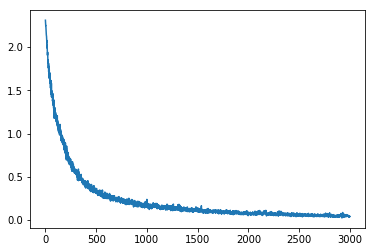

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))